- set up git (add your name and email once) and pull the repo

In [1]:
# change wd to team working directory
import os
os.chdir('/scratch/ws/gpu16-d3hack2019-DeepHydro/')
#!git config --global user.name "Lennart Schmidt"
#!git config --global user.email "lennart.schmidt@ufz.de"
#!git pull
#!hostname

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd

Using TensorFlow backend.


In [3]:
!pwd

/lustre/scratch2/ws/gpu16-d3hack2019-DeepHydro


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
from skimage.external import tifffile
import skimage
skimage.__version__

'0.14.1'

In [5]:
#data_folder = 'Data/Rawtiff/'
#data_prec = '01_prec_rawtiff.tif'
#data_temp = '01_temp_rawtiff.tif'
#data_elev = '01_dem_rawtiff.tif'
#data_disc = '01_discharge.csv'


data_folder = './Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [6]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('./src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- read output data

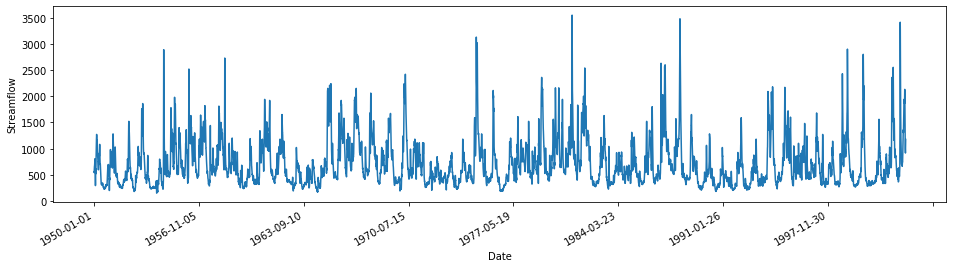

In [7]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)

visualization.plot_streamflow(df=df)

In [8]:
df.tail()

Unnamed: 0        Time         Q  DOY  DiffToMidSummer      FDOY
19353       46808  2002-12-27   975.286  361         0.989041  0.986339
19354       46809  2002-12-28  1031.810  362         0.991781  0.989071
19355       46810  2002-12-29  1081.370  363         0.994521  0.991803
19356       46811  2002-12-30  1131.740  364         0.997260  0.994536
19357       46812  2002-12-31  1174.110  365         1.000000  0.997268

### Load data directly as .npy files

In [9]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [10]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


In [11]:
x_prec[:, x_mask == True] = np.nan
x_temp[:, x_mask == True] = np.nan

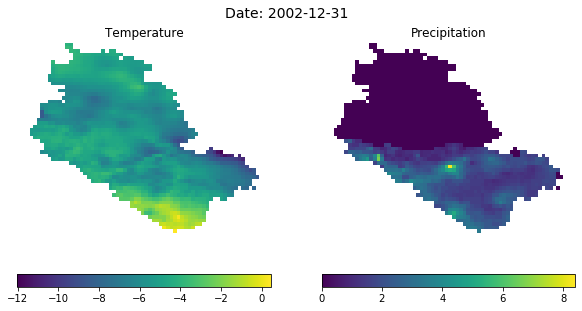

In [12]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, frame=-1)

In [13]:
mean_temp = []
mean_prec = []
for i in range(x_temp.shape[0]):
    mean_temp.append(np.nanmean(x_temp[i]))
    mean_prec.append(np.nanmean(x_prec[i]))

df["mean_prec"] = mean_prec
df["mean_temp"] = mean_temp

In [14]:
df.tail()

Unnamed: 0        Time         Q  DOY  DiffToMidSummer      FDOY  \
19353       46808  2002-12-27   975.286  361         0.989041  0.986339   
19354       46809  2002-12-28  1031.810  362         0.991781  0.989071   
19355       46810  2002-12-29  1081.370  363         0.994521  0.991803   
19356       46811  2002-12-30  1131.740  364         0.997260  0.994536   
19357       46812  2002-12-31  1174.110  365         1.000000  0.997268   

       mean_prec  mean_temp  
19353   0.614431   0.610334  
19354   1.243649   1.717662  
19355  10.186704   3.754925  
19356  14.087836   3.125038  
19357   0.977162  -5.226691

In [15]:
# x: stack temperature and precipitation data
x = np.stack([df.mean_temp, df.mean_prec], axis=-1)

# x: fractional day of year data
x_doy = df['Time'].values

# y: streamflow data
y = df['Q'].values

In [16]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


## Data Preparation

- split train and validation data

# split train and validation data
validation_fraction = 0.2
validation_first = False


val_size = int(validation_fraction * x.shape[0])
train_size = x.shape[0] - val_size

if validation_first:
    x_train, x_val = x[val_size:], x[:val_size]
    y_train, y_val = y[val_size:], y[:val_size]
    time_axis_train, time_axis_val  = time_axis[val_size:], time_axis[:val_size]
    
else:
    x_train, x_val = x[:train_size], x[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    time_axis_train, time_axis_val = time_axis[:train_size], time_axis[train_size:]


In [17]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 2)
Shape of y_val   =  (3871,)


- standardize output data (`y`)

In [18]:
Y_MEAN, Y_STD = y_train.mean(), y_train.std()

y_train = (y_train - Y_MEAN)/Y_STD
y_val   = (y_val -   Y_MEAN)/Y_STD

In [19]:
Y_STD

426.762298097542

In [20]:
X_MEAN, X_STD = x_train.mean(), x_train.std()
x_train = (x_train - X_MEAN)/X_STD
x_val = (x_val - X_MEAN)/X_STD

In [21]:
#y_train = y_train.replace([np.inf, -np.inf], np.nan)
#y_val = y_val.replace([np.inf, -np.inf], np.nan)


#x_train = x_train[~x_train.isin([np.nan, np.inf, -np.inf]).any(1)]
#x_val = x_val[~x_val.isin([np.nan, np.inf, -np.inf]).any(1)]

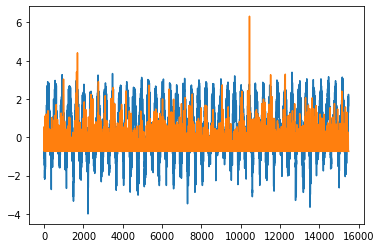

In [22]:
plt.plot(x_train)

In [23]:
input_shape = x_train.shape
n_units = 80
n_layers = 3
n_frames = 70 # length of image sequence: how many days of data to predict streamflow?

In [24]:
from keras import layers, models
i = layers.Input(shape = (n_frames, 2)) # (?, n_frames, channels) 

# add the lstm layers
x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(i) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=False)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
#n_units *= 2            

#x = layers.Flatten()(x)
dropout_rate = 0.5
n_units = int(128*(1/dropout_rate))
x = layers.Dense(n_units)(x)
x = layers.Dropout(rate=dropout_rate)(x, training=True)
x = layers.Activation('relu')(x)

mu     = layers.Dense(1, activation = 'linear')(x) # mean
logvar = layers.Dense(1, activation = 'linear')(x) # log-variance

o = layers.Concatenate()([mu, logvar])

W0913 14:20:52.577828 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 14:20:52.594370 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 14:20:52.597533 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 14:20:54.267882 35184372383840 deprecation.py:506] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.pyt

In [25]:
model = models.Model(inputs=[i], outputs=[o])

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70, 2)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 70, 80)       26560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 70, 160)      154240      lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 70, 320)      615680      lstm_2[0][0]                     
__________________________________________________________________________________________________
lstm_4 (LS

In [27]:
from keras import optimizers, losses, metrics
from deephydro.losses import gauss
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=gauss)
              #metrics=[metrics.mse])

W0913 14:20:59.769407 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [28]:
from keras import utils
class ImageSequenceGenerator(utils.Sequence):
    '''Generates image sequences'''

    def __init__(self, data, labels, batch_size=32, n_frames=5, uncertainty=False):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames
        self.uncertainty = uncertainty

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''

        batch_x, batch_y = [], []

        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data) - self.n_frames)
            stop_index = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index]
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        if self.uncertainty:
            # in case we are training a model with uncertainty
            # add an axis to make the targets y_true the same dimensionality as the predictions y_pred
            batch_y = batch_y[..., np.newaxis] # add axis

        return batch_x, batch_y

In [29]:
#y_train = y_train.values[..., np.newaxis]
#y_val = y_val.values[..., np.newaxis]

In [30]:
n_epochs = 20
batch_size = 240

generator_train = ImageSequenceGenerator(data = x_train, labels = y_train, batch_size = batch_size, n_frames = n_frames, 
                                         uncertainty=True)
generator_test  = ImageSequenceGenerator(data = x_val, labels = y_val, batch_size = batch_size, n_frames = n_frames,
                                        uncertainty=True)


batch = generator_test.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')

Shape of batch_x = (240, 70, 2)
Shape of batch_y = (240, 1)


In [31]:
batch = generator_test.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')

Shape of batch_x = (240, 70, 2)
Shape of batch_y = (240, 1)


In [32]:
history = model.fit_generator(generator = generator_train,
                              steps_per_epoch = len(x_train)//batch_size,
                              epochs = n_epochs,
                              validation_data = generator_test,
                              validation_steps = len(x_val)//batch_size)

W0913 14:21:11.535722 35184372383840 deprecation.py:323] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0913 14:21:13.636960 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0913 14:21:13.842031 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
64/64 [==============================] - 47s 730ms/step - loss: 0.3705 - val_loss: 0.0483
Epoch 2/20
64/64 [==============================] - 41s 638ms/step - loss: 0.0667 - val_loss: -0.2272
Epoch 3/20
64/64 [==============================] - 40s 617ms/step - loss: -0.1697 - val_loss: -0.3842
Epoch 4/20
64/64 [==============================] - 40s 621ms/step - loss: -0.3058 - val_loss: -0.4356
Epoch 5/20
64/64 [==============================] - 40s 623ms/step - loss: -0.3450 - val_loss: -0.3696
Epoch 6/20
64/64 [==============================] - 40s 619ms/step - loss: -0.3629 - val_loss: -0.3615
Epoch 7/20
64/64 [==============================] - 41s 638ms/step - loss: -0.3761 - val_loss: -0.3324
Epoch 8/20
64/64 [==============================] - 41s 645ms/step - loss: -0.4225 - val_loss: -0.4323
Epoch 9/20
64/64 [==============================] - 40s 624ms/step - loss: -0.4372 - val_loss: -0.4298
Epoch 10/20
64/64 [==============================] - 40s 623ms/step - loss: 

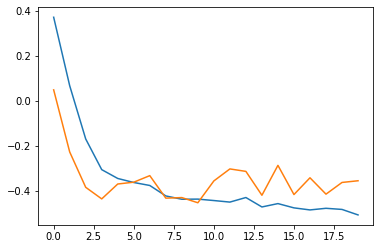

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Predict

In [46]:
from deephydro.inference import predict_timeseries

maxtime = len(x_val) # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=batch_size, 
                                    Y_MEAN=Y_MEAN, Y_STD=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                    uncertainty=True,
                                    T=10,
                                    n_gpus=4)

Running inference on 4 GPUs.
0 / 3801


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[ 1.71404563, -0.72209354],
        [ 1.60138834, -0.7344897 ],
        [ 1.60788238, -0.73571095],
        ...,
        [ 2.64004656, -0.73167072],
        [ 2.95390659, -0.40267678],
      ...

In [52]:
model=model
data=x_val[:maxtime]
doy=x_doy_val[:maxtime]
df=df_val[:maxtime]
n_frames=n_frames
stride=1
batch_size=batch_size
#Y_MEAN=Y_MEAN, Y_STD=Y_STD
gt=y_val[:maxtime]
plot=True
uncertainty=True
T=10
n_gpus=4
predict_uncertainty = True

In [54]:
y_preds, y_vars_all = predict_uncertainty(model, input_data, T=T)

TypeError: 'bool' object is not callable

In [53]:
if n_gpus > 1:
    from keras.utils import multi_gpu_model
    model = multi_gpu_model(model, gpus=n_gpus)
    print(f'Running inference on {n_gpus} GPUs.')

predictions  = np.array([])
if uncertainty: 
    uncertainties = np.array([])
    uncertainties_epi = np.array([])
    uncertainties_alea = np.array([])
ground_truth = np.array([])
n_samples = (len(data)-n_frames) // stride
index = 0

while len(predictions) < n_samples:
    print(f'{len(predictions)} / {n_samples}')

    # get a batch of inputs (largely overlapping)
    iterator = range(index, min(index+batch_size, n_samples), stride)
    batch = np.array([data[i : i+n_frames] for i in iterator])
    if doy is not None:
        batch_doy = np.array([doy[i+n_frames] for i in iterator])
    y_trues = np.array([gt[i+n_frames] for i in iterator])

    index += batch_size

    if doy is None:
        input_data = batch
    else:
        input_data = [batch, batch_doy]

    if uncertainty:
        y_preds, y_vars_all = predict_uncertainty(model, input_data, T=T)
        y_vars, y_vars_epi, y_vars_alea = y_vars_all
    else:
        y_preds = np.squeeze(model.predict(input_data))

    # rescale prediction 
    with_rescaling = False
    if Y_MEAN is not None and Y_STD is not None:
        with_rescaling = True

    if with_rescaling:
        y_preds = y_preds * Y_STD + Y_MEAN
        y_trues = y_trues * Y_STD + Y_MEAN
        if uncertainty: 
            y_stds      = np.sqrt(y_vars) * Y_STD
            y_stds_epi  = np.sqrt(y_vars_epi) * Y_STD
            y_stds_alea = np.sqrt(y_vars_alea) * Y_STD

#             if with_rescaling:
#                 y_preds = np.exp(y_preds * Y_STD + Y_MEAN)
#                 y_trues = np.exp(y_trues * Y_STD + Y_MEAN)
#                 if uncertainty: 
#                     y_stds = np.exp(y_stds * Y_STD) 

#             if with_rescaling:                
#                 y_trues = np.exp(y_trues*Y_STD + Y_MEAN)
#                 y_preds_log = y_preds*Y_STD + Y_MEAN

#                 if uncertainty: 
#                     y_vars_log = y_vars*Y_STD                     
#                     y_preds = np.exp(y_preds_log + y_vars_log/2)
#                     y_vars  = (np.exp(y_vars_log)-1) * np.exp(2*y_preds+y_vars_log)


    predictions  = np.concatenate([predictions, y_preds])
    ground_truth = np.concatenate([ground_truth, y_trues])
    if uncertainty: 
        uncertainties      = np.concatenate([uncertainties, y_stds])
        uncertainties_epi  = np.concatenate([uncertainties_epi, y_stds_epi])
        uncertainties_alea = np.concatenate([uncertainties_alea, y_stds_alea])
            

Running inference on 4 GPUs.
0 / 3801


TypeError: 'bool' object is not callable

In [ ]:
from deephydro.utils import predict
batch = generator_test.__getitem__(0)
im = batch[0][0]
#gt = batch[1][0] * Y_STD + Y_MEAN
gt = batch[1][0]
y_pred = predict(model, image=im)
print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

In [ ]:
#df[:train_size]

In [ ]:
from deephydro.inference import predict_timeseries
x, y = predict_timeseries(model, 
                          x_val.values[np.newaxis, ...], 
                          doy = None, 
                          df = df[:train_size], 
                          n_frames = 70, 
                          Y_MEAN = Y_MEAN, 
                          Y_STD = Y_STD, 
                          gt = y_val.values, 
                          plot = False, 
                          uncertainty = True, 
                          T = 10, 
                          n_gpus = 4)

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(x, y)

In [ ]:
x_val.flatten()

In [ ]:
predictions = []
for t in range(0, len(x_val)-n_frames):
    data = x_val[t:t+n_frames].values
    data = data[np.newaxis, ...]
    p = model.predict( data )
    predictions.append(p)

In [ ]:

flat_list = [item for sublist in predictions for item in sublist]

flat_list = [item for sublist in flat_list for item in sublist]


In [ ]:
batch_size

In [ ]:
pd.concat([y_val.reset_index(drop = True), pd.DataFrame(flat_list).shift(periods=74)], axis = 1).plot(figsize=(12,5))

#plt.plot(flat_list)

In [ ]:
pd.concat([y_val.reset_index(drop = True), pd.DataFrame(flat_list).shift(periods=10)], axis = 1)

In [ ]:
n_frames 

In [ ]:
iterator = range(index, min(index+batch_size, n_samples), stride)
batch = np.array([data[i : i+n_frames] for i in iterator])
if doy is not None:
    batch_doy = np.array([doy[i+n_frames] for i in iterator])
y_trues = np.array([gt[i+n_frames] for i in iterator])


In [34]:
from deephydro.utils import predict_batch
x, y = predict_batch(model, generator=generator_test, n_samples=5000)

ImportError: cannot import name 'predict_batch'

In [ ]:
model = model 
data = x_val.values[np.newaxis, ...], 
doy = None, 
df = df[:train_size], 
n_frames = 70
Y_MEAN = Y_MEAN, 
Y_STD = Y_STD, 
gt = y_val.values, 
plot = False, 
uncertainty = True, 
T = 10, 
n_gpus = 4
stride = 2
doy = None


predictions  = np.array([])
if uncertainty: uncertainties= np.array([])
ground_truth = np.array([])
n_samples = (train_size-n_frames) // stride
index = 0

while len(predictions) < n_samples:
    print(f'{len(predictions)} / {n_samples}')

    # get a batch of inputs (largely overlapping)
    iterator = range(index, min(index+batch_size, n_samples), stride)
    batch = np.array([data[i : i+n_frames] for i in iterator])
    if doy is not None:
        batch_doy = np.array([doy[i+n_frames] for i in iterator])
    y_trues = np.array([gt[i+n_frames] for i in iterator])

    index += batch_size

    if doy is None:
        input_data = batch
    else:
        input_data = [batch, batch_doy]

    if uncertainty:
        y_preds, y_stds = predict_uncertainty(model, input_data, T=T)
    else:
        y_preds = np.squeeze(model.predict(input_data))

    # rescale prediction 
    with_rescaling = False
#             if Y_MEAN is not None and Y_STD is not None:
#                 with_rescaling = True

    if with_rescaling:
        y_preds = np.exp(y_preds * Y_STD + Y_MEAN)
        y_trues = np.exp(y_trues * Y_STD + Y_MEAN)
        if uncertainty: y_stds = np.exp(y_stds *  Y_STD) 

    predictions  = np.concatenate([predictions, y_preds])
    ground_truth = np.concatenate([ground_truth, y_trues])
    if uncertainty: uncertainties = np.concatenate([uncertainties, y_stds])




In [ ]:
time_axis_train, time_axis_val  = time_axis[train_size:], time_axis[:train_size]

In [ ]:
#x_val.append(pd.DataFrame(y_val, columns=['Q']))
#x_val.append(pd.DataFrame(time_axis_val, columns=['Time']))

tmp_x_val = pd.concat(x_val, y_val, df. axis=1)
tmp_x_val.append(pd.DataFrame(y_val, columns=['Q']).reset_index(drop=True), ignore_index=True)

In [ ]:
[x_val, pd.DataFrame(y_val, columns=['Q']),  pd.DataFrame(time_axis_val, columns=['Time'])]

In [ ]:
import pandas as pd            
df = pd.DataFrame({'Time':df['Time'][:-n_frames],
                    'Q':ground_truth,
                    'Q_pred':predictions})

In [ ]:
ground_truth

In [ ]:
plt.plot(x)
plt.plot(y)

In [ ]:
df_val =

In [ ]:
x_val.append(y_val)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [ ]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)